# Case 2.
### Predicting pneumonia with Convolutional Neural Networks
Team 15: Esa Ryömä, Jan Aalto, Oskar Rönnberg<br>
Last edited: 12.2.2020<br>
Neural Networks for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

## Background
The purpose of this notebook excercise is to create a convolutional neural network which is able to predict if a patient has symptoms of pneumonia based on chest x-ray images. Another aim is to discuss some ways to improve network performance (mainly, more accurate prediction rate). Three different networks are trained with training data of x-ray images, validated and finally tested. Benefits of data augmentation and using a pretrained network are considered based on validation and test metrics.

## Data
The dataset used (Kermany & al. 2018) contains 5855 chest x-ray images divided into two categories: images of patients displaying symptoms of pneumonia, and images of those who do not. After downloading, they were manually divided into three sets: a training set containing 60% of those images, validation set of 20% and finally a test set of the last 20%. The images are of varying pixel size with 8-bit colours. Each image contains 3 values: horizontal size X, vertical size Y, and color coding ranging 0-255 (RGB). 

In [1]:
# Imports
%pylab inline
import pandas as pd 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.metrics import Accuracy,FalseNegatives, FalsePositives
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

Populating the interactive namespace from numpy and matplotlib


C:\Users\I\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\I\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\I\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\I\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
# Save directories into variables
base_dir = r'C:\Users\I\Desktop\Neural networks\Neural network data\Case2'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

## Building model

Images are taken in as 150 x 150 pixels. Then using Conv2D layers as (3, 3) to reduce picture by 2 x 2 over every Conv2D layer. MaxPooling2D is used as (2, 2) divide the pixel size by a factor of 2, in every MaxPooling2D. The last conv2D layer produces a (5, 5, 256).The changes to the picture size can been seen from the model summary below.

The final layer has a sigmoid activation function, which produces a result of range 0-1 for every xray image: if the result is closer to 0, the patient is healthy; if the result is closer to 1, the patient has pneumonia. The limit for this classification can also be changed (e.g. sigmoid result < 0.6 would mean the result to interpreted as 0)

With regards to the network proficiency after training, image preprocessing is far more important than changing the layers after flatten()-function. How the neural network changes each input picture in MaxPooling2D and Conv2D layers is much more important than node value et cetera. That is because in the first layers the network will learn what are the important features in image recognition. How well the first layers can identify the "important" features in different pictures is the most important stage, because all further recognition is based on desicions made on upper layers. That is why we decided to focus on upper layers and go identical layers after flattening layer in all 3 versions.

The model is compiled with the binary crossentropy loss function which is well-suited for binary classification problems such as this case.

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

### Create data generators

For use in machine learning, the data is preprocessed in two ways. First, when creating the ImageDataGenerator, which processes the image files from data folders into memory, the RGB value of every pixel is scaled down into 1/255. This means, instead of a range of 0-255, the RGB part of the tensor is of range 0-1. Next, each image is resized from its original size into 150x150 pixels. 

In [5]:
#Rescale Images
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    #shuffle=False,
    class_mode='binary')

all_metrics = ['acc', FalseNegatives(), FalsePositives()] 

model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=2e-5),
            metrics=all_metrics)

Found 3512 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
# Actual training happens with fit.generator() function, where the number of epochs is given as a parameter.
history = model.fit_generator(
            train_generator,
            #steps_per_epoch=100,
            epochs=50,
            validation_data=validation_generator)#,
            #validation_steps=50)

Epoch 1/50
110/110 [==============================] - 63s 577ms/step - loss: 0.5738 - acc: 0.7286 - false_negatives: 17.0000 - false_positives: 936.0000 - val_loss: 0.5483 - val_acc: 0.7295 - val_false_negatives: 0.0000e+00 - val_false_positives: 317.0000
Epoch 2/50
110/110 [==============================] - 60s 550ms/step - loss: 0.4774 - acc: 0.7548 - false_negatives: 23.0000 - false_positives: 838.0000 - val_loss: 0.4028 - val_acc: 0.8276 - val_false_negatives: 23.0000 - val_false_positives: 179.0000
Epoch 3/50
110/110 [==============================] - 58s 529ms/step - loss: 0.3596 - acc: 0.8531 - false_negatives: 110.0000 - false_positives: 406.0000 - val_loss: 0.3137 - val_acc: 0.8780 - val_false_negatives: 36.0000 - val_false_positives: 107.0000
Epoch 4/50
110/110 [==============================] - 58s 530ms/step - loss: 0.3047 - acc: 0.8739 - false_negatives: 169.0000 - false_positives: 274.0000 - val_loss: 0.2788 - val_acc: 0.8891 - val_false_negatives: 38.0000 - val_false_pos

# Training and validation results
First, the metrics accuracy, loss, false positives and false negatives are explained in short. Then, graphs for said metrics are shown first without smoothing (true graph) then with smoothing (smoothes small variances in graph). Discussion of results proceeds after the graphs.

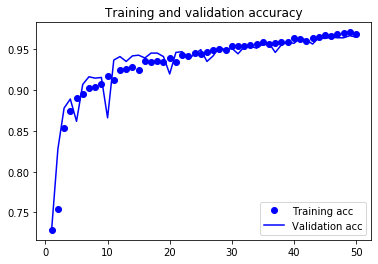

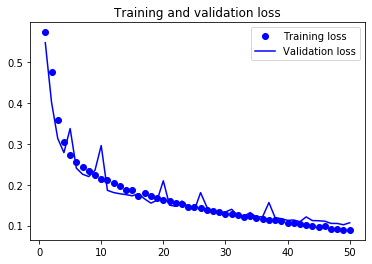

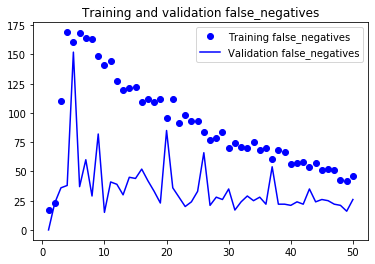

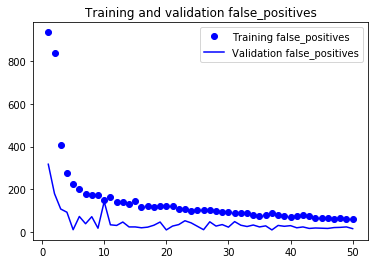

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
fn = history.history['false_negatives']
fn_v = history.history['val_false_negatives']
fp = history.history['false_positives']
fp_n = history.history['val_false_positives']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, fn, 'bo', label='Training false_negatives')
plt.plot(epochs, fn_v, 'b', label='Validation false_negatives')
plt.title('Training and validation false_negatives')
plt.legend()
plt.figure()
plt.plot(epochs, fp, 'bo', label='Training false_positives')
plt.plot(epochs, fp_n, 'b', label='Validation false_positives')
plt.title('Training and validation false_positives')
plt.legend()
plt.show()

The curves are smoothened so that the visual changes and trends (overfitting) are easier to spot when every little jump in data is not so prominently visible. 

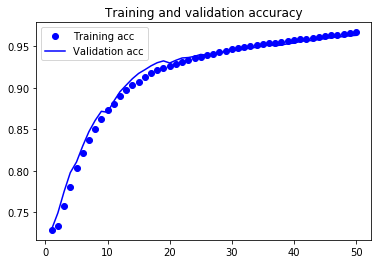

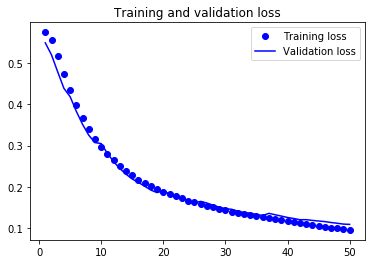

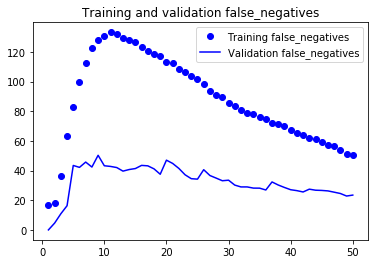

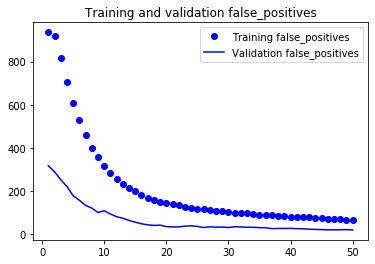

In [8]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
#smooth_curve(loss)
#Smoothed validation loss
plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(fn), 'bo', label='Training false_negatives')
plt.plot(epochs, smooth_curve(fn_v), 'b', label='Validation false_negatives')
plt.title('Training and validation false_negatives')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(fp), 'bo', label='Training false_positives')
plt.plot(epochs, smooth_curve(fp_n), 'b', label='Validation false_positives')
plt.title('Training and validation false_positives')
plt.legend()
plt.show()

### Discussion

The results are surprisingly good already in this model which does not use any advanced model building methods. 

Accuracy does not seem to increase over 95%. Probably the "limit" of the model is reached.

Loss function keeps going lower, as it should. There is a slight upward trend before epoch 50, so the model might suffer from overfitting after epoch 50.

Controversely, it seems that false negatives would benefit from more training. At the 50 epoch limit there still is a strong downward slope.

# Testing the model
Finally, the test set is run through the network. The network is then evaluated with a confusion matrix and a classification report.

In [9]:
#Evaluate the data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    shuffle=False,
    class_mode='binary')
test_loss, test_acc, test_falseNegatives, test_falsePositives = model.evaluate_generator(test_generator)#test_generator
print('test acc:', test_acc)
print('test loss:', test_loss)
print('test false negatives',test_falseNegatives)
print('test false positives',test_falsePositives)
model.save('Case 2.V1.h5')

Found 1170 images belonging to 2 classes.
test acc: 0.9564102
test loss: 0.1109180979531359
test false negatives 34.0
test false positives 17.0


# Prediction / true values graph

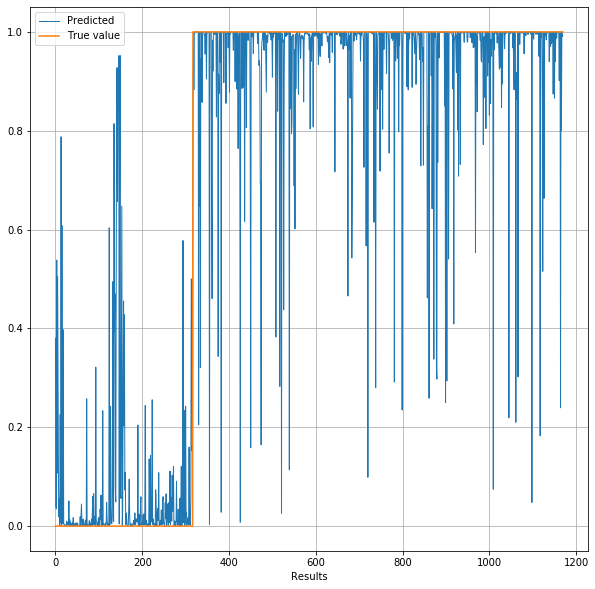

In [10]:
fig = plt.figure(figsize=(10, 10))
labels = test_generator.classes
prediction = model.predict_generator(test_generator).flatten()#, steps=50
plot(prediction, label='Predicted', linewidth=1)
plot(labels, label='True value')
legend()
xlabel('Results')
grid()

From the Prediction/True value graph above we can see the variance of the results compared to the actual values. When results should be 0, there is quite a spike in misidentified pictures at 0-10, 150-180. When results should be 1, there is quite a spike in miss identified pictures at 530-550, 710-730 and 850-900. The graph is readable but it could definetely be more accurate in its predictions.

In [11]:
# Print confusion matrix and classification raport

cf_mx = confusion_matrix(labels, prediction > 0.25)
print("Confusion matrix: ")
print(cf_mx)
tn, fp, fn, tp = confusion_matrix(labels, prediction  > 0.25).ravel()
sensitivity = tp/(fn+tp)
specificity = tn/(fp+tn)
print("Sensitivity",sensitivity)
print("Specificity",specificity)
cl_rt = classification_report(labels, prediction > 0.25, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(cl_rt)
# Confusion matrix:
# TN FP
# FN TP
# FN False Negative
# FP False Positive
# TN True Negative
# TP True Positive

# Precision = TP / Number of actually positive patients
# Recall = Sensitivity = TP / Number of model predicted positive patients

Confusion matrix: 
[[285  32]
 [ 17 836]]
Sensitivity 0.9800703399765534
Specificity 0.8990536277602523
               precision    recall  f1-score   support

   Normal (0)       0.94      0.90      0.92       317
Pneumonia (1)       0.96      0.98      0.97       853

     accuracy                           0.96      1170
    macro avg       0.95      0.94      0.95      1170
 weighted avg       0.96      0.96      0.96      1170



## Test results

First, a short briefing of the metrics printed is shown. Finally, a discussion of results is given.

Sensitivity (also called true positive rate, or recall) is the percentage with which the model predicts or "catches" positive cases from the data. A sensitivity of 0.7 means that from all actually positive patients in the x-ray data, the model was able to predict correctly 70% of them.
Specificity (also called true negative rate) is a similar percentage but for the network's ability to "catch" negative cases. With both metrics, bigger percentages mean a more qualified network.

Accuracy is the network's ability to predict results correctly: how many times the model gives the right diagnosis ((TP + TN) / all cases).

Precision is how well the model predicts the true disease: TP / (TP + FP)

Being a model without advanced modeling techniques used in version 2 notebook, this model gave surprising results. At first glance, model accuracy is very high at 96%. Sensitivity is also high at 98%, but specificity is not so good at 90%. Also recall of sick patients is quite high at 98%, but recall of healthy patients is only at 90%.

In notebook version 2, a few methods which should improve the network modeling are tried out.
